In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, DenseNetwork, set_seed, Network
import os

from tensorflow.keras.optimizers import SGD

In [2]:
seed = 101
name = 'network_10'
tracks = 'tracks_04c'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [3]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

In [5]:
len(train)

7736000

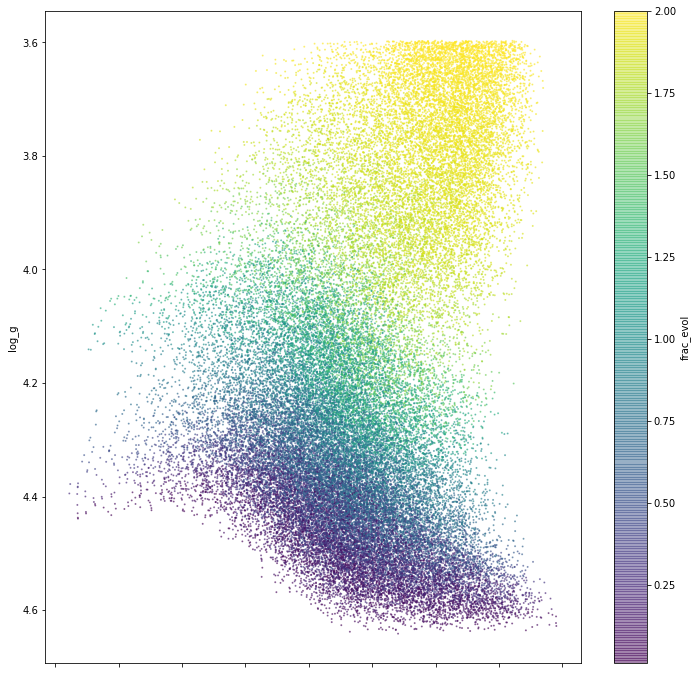

In [6]:
ax = train.sample(50000).plot(kind='scatter', x='effective_T', y='log_g',
                              c='frac_evol', cmap='viridis', s=1, figsize=(12, 12), alpha=0.5)
ax.invert_xaxis()
ax.invert_yaxis();

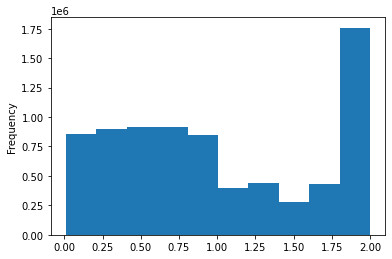

In [7]:
train.frac_evol.plot(kind='hist')

In [8]:
t = Tracks(name=tracks)
t.set_data(train)

del train

In [9]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,radius,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,frac_evol,gradient,log_star_age
0,2,0.90,0.28,0.30,2.1,1.208001,5096.0684,1.257615,1.440663,4.074041,0.250045,0.023094,0.244397,75.369644,0.025096,1.787780,0.001331,1.288534
1,1,1.05,0.30,0.35,2.3,0.802252,5795.2236,1.241361,1.106796,4.370944,0.265167,0.024596,0.281803,119.692590,0.027260,0.802252,0.000143,0.769161
2,1,1.00,0.26,0.45,1.5,0.257848,4885.7940,0.461555,0.949512,4.482889,0.244987,0.034190,0.418402,147.281680,0.035917,0.257848,0.000186,0.602735
3,1,0.83,0.24,0.10,1.7,0.133108,4709.6700,0.263781,0.772503,4.581167,0.230248,0.016330,0.078280,182.489150,0.016932,0.133108,0.000198,0.506814
4,1,1.20,0.32,-0.40,1.7,0.570906,7567.7803,5.058152,1.310140,4.282435,0.211951,0.003404,-0.620390,90.396866,0.004865,0.570906,0.000695,0.055732


In [10]:
len(t._data)

7736000

## Normalize

Let's choose the inputs and outputs and the normalise

In [11]:
x_cols = ['frac_evol', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'radius', 'delta_nu_fit', 'star_feh']

In [12]:
factors, _df = t.normalize(loc='50%', scale='std', columns=x_cols+y_cols)

In [13]:
factors

,column,norm_column,loc,scale
0,frac_evol,frac_evol_norm,0.864733,0.650730
1,initial_mass,initial_mass_norm,1.000000,0.117961
2,initial_MLT,initial_MLT_norm,1.900000,0.337950
3,initial_Yinit,initial_Yinit_norm,0.280000,0.028038
4,initial_Zinit,initial_Zinit_norm,0.016932,0.010687
5,log_star_age,log_star_age_norm,0.790410,0.466884
6,effective_T,effective_T_norm,5566.772000,601.172445
7,radius,radius_norm,1.223618,0.502612
8,delta_nu_fit,delta_nu_fit_norm,100.720155,42.581806
9,star_feh,star_feh_norm,0.081029,0.360937


Round the loc and scale to 3 dp

In [14]:
factors = round(factors, 3)

In [15]:
factors

,column,norm_column,loc,scale
0,frac_evol,frac_evol_norm,0.865,0.651
1,initial_mass,initial_mass_norm,1.000,0.118
2,initial_MLT,initial_MLT_norm,1.900,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.017,0.011
5,log_star_age,log_star_age_norm,0.790,0.467
6,effective_T,effective_T_norm,5566.772,601.172
7,radius,radius_norm,1.224,0.503
8,delta_nu_fit,delta_nu_fit_norm,100.720,42.582
9,star_feh,star_feh_norm,0.081,0.361


In [16]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,1.417480,-0.847458,0.591716,0.000000,0.735994,1.067524,-0.782977,0.430741,-0.595330,0.452623
1,-0.096387,0.423729,1.183432,0.714286,0.932727,-0.044623,0.380010,-0.233010,0.445554,0.556240
2,-0.932645,0.000000,-1.183432,-0.714286,1.719745,-0.400995,-1.132751,-0.545702,1.093459,0.934632
3,-1.124259,-1.440678,-0.591716,-1.428571,-0.006186,-0.606395,-1.425718,-0.897609,1.920275,-0.007535
4,-0.451758,1.694915,-0.591716,1.428571,-1.103196,-1.572307,3.328512,0.171253,-0.242430,-1.942907


In [17]:
del _df

In [18]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [19]:
t.norm_factors.to_csv(os.path.join(save_path, f'{name}_norm.csv'), index=False)

In [20]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols]+['gradient'])
train.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm,gradient
0,1.417480,-0.847458,0.591716,0.000000,0.735994,1.067524,-0.782977,0.430741,-0.595330,0.452623,0.001331
1,-0.096387,0.423729,1.183432,0.714286,0.932727,-0.044623,0.380010,-0.233010,0.445554,0.556240,0.000143
2,-0.932645,0.000000,-1.183432,-0.714286,1.719745,-0.400995,-1.132751,-0.545702,1.093459,0.934632,0.000186
3,-1.124259,-1.440678,-0.591716,-1.428571,-0.006186,-0.606395,-1.425718,-0.897609,1.920275,-0.007535,0.000198
4,-0.451758,1.694915,-0.591716,1.428571,-1.103196,-1.572307,3.328512,0.171253,-0.242430,-1.942907,0.000695


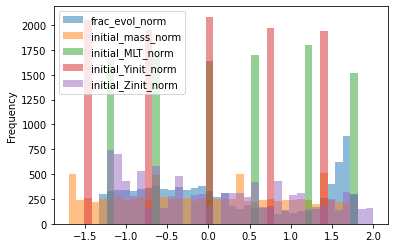

In [21]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols], bins=40, alpha=0.5)

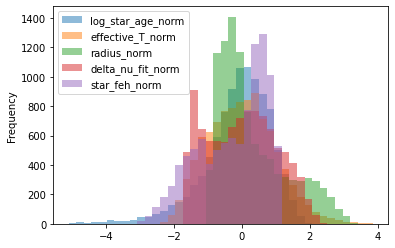

In [22]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Normalise training weights such that they are of order 1

In [23]:
train['weight'] = train['gradient']/train['gradient'].std()

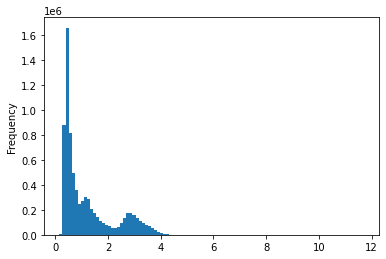

In [24]:
train['weight'].plot(kind='hist', bins=100)

Validation

In [25]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [26]:
t = Tracks()
t.set_data(val)

In [27]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [28]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_evol_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,radius_norm,delta_nu_fit_norm,star_feh_norm
0,-1.309110,0.0,1.183432,-1.428571,-0.56619,-3.698857,0.325369,-0.700701,1.533307,-0.504890
1,-1.302925,0.0,1.183432,-1.428571,-0.56619,-3.443982,0.327236,-0.697468,1.522501,-0.506281
2,-1.278154,0.0,1.183432,-1.428571,-0.56619,-2.818129,0.333134,-0.688479,1.492790,-0.511842
3,-1.273483,0.0,1.183432,-1.428571,-0.56619,-2.735962,0.334265,-0.687043,1.488078,-0.512881
4,-1.225451,0.0,1.183432,-1.428571,-0.56619,-2.154124,0.346240,-0.673718,1.444744,-0.523512


In [29]:
del t

In [30]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [31]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 7736000
Length of validation data = 1933666


In [32]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 500  800  967 1000 1600 1934]


In [33]:
len(train)//500

15472

In [35]:
depth = 6
width = 128
activation = 'elu'
batch_size = len(train)//500
regularization_l2 = 1e-6
optimizer = SGD(0.0001, 0.999)
loss = 'mae'
metrics = ['mae']

In [36]:
def get_config(self):
    config = dict(
        name=self.name,
        model_filename=self.model_filename,
        history_filename=self.history_filename,
        optimizer=str(self.optimizer),
        loss=self.loss,
        metrics=self.metrics,
        x_cols=self.x_cols,
        y_cols=self.y_cols
        )
    return config

In [37]:
Network.get_config = get_config

In [38]:
network = DenseNetwork(path=save_path, name=name, depth=depth, width=width,
                       activation=activation, batch_size=batch_size, regularization_l2=regularization_l2)

In [39]:
network.build(len(x_cols), len(y_cols))

In [40]:
network.compile(optimizer=optimizer, loss=loss, metrics=metrics)
network.save()

In [41]:
fit_kw = {'sample_weight': train['weight'].to_numpy()}

In [ ]:
network.train(train, x_cols, y_cols, epochs=10000, validation_split=None, validation_data=val,
              callbacks=['checkpoint', 'tensorboard'], fit_kw=fit_kw)

  ...
    to  
  ['...']


In [ ]:
network.save()

In [ ]:
network.plot_metric(val.sample(20000), metric='absolute_error');

In [ ]:
network.plot_metric(val.sample(20000), metric='error');

In [ ]:
scores = network.scores(val.sample(20000))
scores

In [ ]:
scale_scores = factors.loc[5:, 'scale'].to_numpy() * scores

In [ ]:
log_cols = [col for col in scale_scores.columns if 'log' in col]
log_cols

scale_scores[[col[4:] for col in log_cols]] = scale_scores[log_cols] * np.log(10.0)

scale_scores.loc['std'].round(5)